# Importing libraries and data


## Libraries


In [1]:
import itk
import vtk

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


## Data Loading


In [2]:
scan1_path = "data/case6_gre1.nrrd"
scan2_path = "data/case6_gre2.nrrd"

scan1 = itk.imread(scan1_path, itk.F)
scan2 = itk.imread(scan2_path, itk.F)

print("scan1: ", scan1.shape)
print("scan2: ", scan2.shape)

vtk_scan1 = itk.vtk_image_from_image(scan1)
vtk_scan2 = itk.vtk_image_from_image(scan2)


scan1:  (176, 256, 256)
scan2:  (176, 256, 256)


## Data Visualization


In [3]:
def show_images(images, index, titles):

    gridX = 1
    gridY = len(images)

    fig = plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = fig.add_subplot(gridX, gridY, i + 1)
        ax.imshow(images[i][index, :, :])
        ax.set_title(titles[i] + " " + str(index))
        ax.axis("off")

    plt.show()


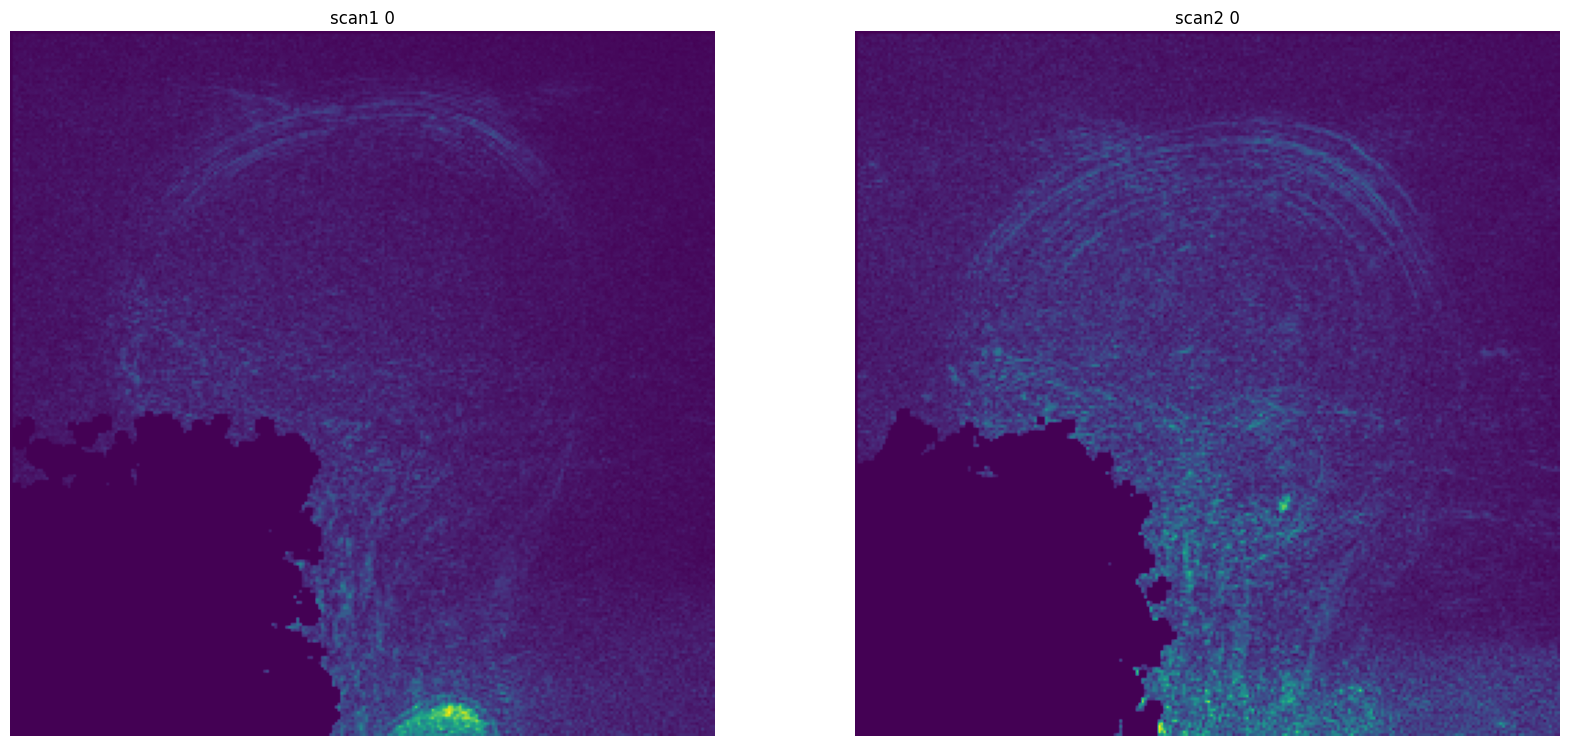

In [4]:
show_images([scan1, scan2], 0, ["scan1", "scan2"])


# Image Repositioning


## Registration

In [60]:
def register(fixed_image, moving_image):

    dimension = fixed_image.GetImageDimension()
    FixedImageType = type(fixed_image)
    MovingImageType = type(moving_image)

    # create registration object
    registration_method = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(
    )

    # set registration method
    registration_method.SetFixedImage(fixed_image)
    registration_method.SetMovingImage(moving_image)

    # set initial transform
    TransformType = itk.TranslationTransform[itk.D, dimension]
    initial_transform = TransformType.New()
    registration_method.SetInitialTransform(initial_transform)

    # set metric
    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New(
    )
    registration_method.SetMetric(metric)

    # set optimizer
    optimizer = itk.RegularStepGradientDescentOptimizerv4[itk.D].New()
    optimizer.SetLearningRate(4)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(200)
    registration_method.SetOptimizer(optimizer)

    # set interpolator
    fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New(
    )
    metric.SetFixedInterpolator(fixed_interpolation)

    # set scales
    # registration_method.SetShrinkFactorsPerLevel([4, 2, 1])
    # registration_method.SetSmoothingSigmasPerLevel([2, 1, 0])
    # registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    moving_initial_transform = TransformType.New()
    initial_parameters = moving_initial_transform.GetParameters()
    initial_parameters[0] = 0
    initial_parameters[1] = 0
    moving_initial_transform.SetParameters(initial_parameters)
    registration_method.SetMovingInitialTransform(moving_initial_transform)

    identity_transform = TransformType.New()
    identity_transform.SetIdentity()
    registration_method.SetFixedInitialTransform(identity_transform)

    registration_method.SetNumberOfLevels(1)
    # registration_method.SetSmoothingSigmasPerLevel([0])
    # registration_method.SetShrinkFactorsPerLevel([1])

    # perform registration
    registration_method.Update()

    # get transform
    final_transform = registration_method.GetTransform()
    final_parameters = final_transform.GetParameters()
    translation_along_x = final_parameters.GetElement(0)
    translation_along_y = final_parameters.GetElement(1)

    number_of_iterations = optimizer.GetCurrentIteration()

    best_value = optimizer.GetValue()

    print("Result =")
    print("Translation X = " + str(translation_along_x))
    print("Translation Y = " + str(translation_along_y))
    print("Iterations    = " + str(number_of_iterations))
    print("Metric value  = " + str(best_value))

    CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
    output_composite_transform = CompositeTransformType.New()
    output_composite_transform.AddTransform(moving_initial_transform)
    output_composite_transform.AddTransform(
        registration_method.GetModifiableTransform())

    return output_composite_transform


In [61]:
final_transform = register(scan1, scan2)
print(final_transform)


Result =
Translation X = -0.7932391841883469
Translation Y = -3.574893649072759
Iterations    = 36
Metric value  = 5614.015384635979
CompositeTransform (0x12960f100)
  RTTI typeinfo:   itk::CompositeTransform<double, 3u>
  Reference Count: 1
  Modified Time: 10464
  Debug: Off
  Object Name: 
  Observers: 
    none
  Transforms in queue, from begin to end:
  >>>>>>>>>
  TranslationTransform (0x16e47d9d0)
    RTTI typeinfo:   itk::TranslationTransform<double, 3u>
    Reference Count: 1
    Modified Time: 9900
    Debug: Off
    Object Name: 
    Observers: 
      none
    Offset: [0, 0, 0]
  >>>>>>>>>
  TranslationTransform (0x16e487050)
    RTTI typeinfo:   itk::TranslationTransform<double, 3u>
    Reference Count: 1
    Modified Time: 10458
    Debug: Off
    Object Name: 
    Observers: 
      none
    Offset: [-0.793239, -3.57489, -59.6102]
  End of MultiTransform.
<<<<<<<<<<
  TransformsToOptimizeFlags, begin() to end(): 
    1 1 
  TransformsToOptimize in queue, from begin to end:

## Apply Transformation

In [62]:
def apply_transform(transform, ref, image):

    resample_filter = itk.ResampleImageFilter.New(image)
    resample_filter.SetTransform(transform)
    resample_filter.SetUseReferenceImage(True)
    resample_filter.SetReferenceImage(ref)

    resample_filter.SetDefaultPixelValue(100)
    resample_filter.Update()
    return resample_filter.GetOutput()


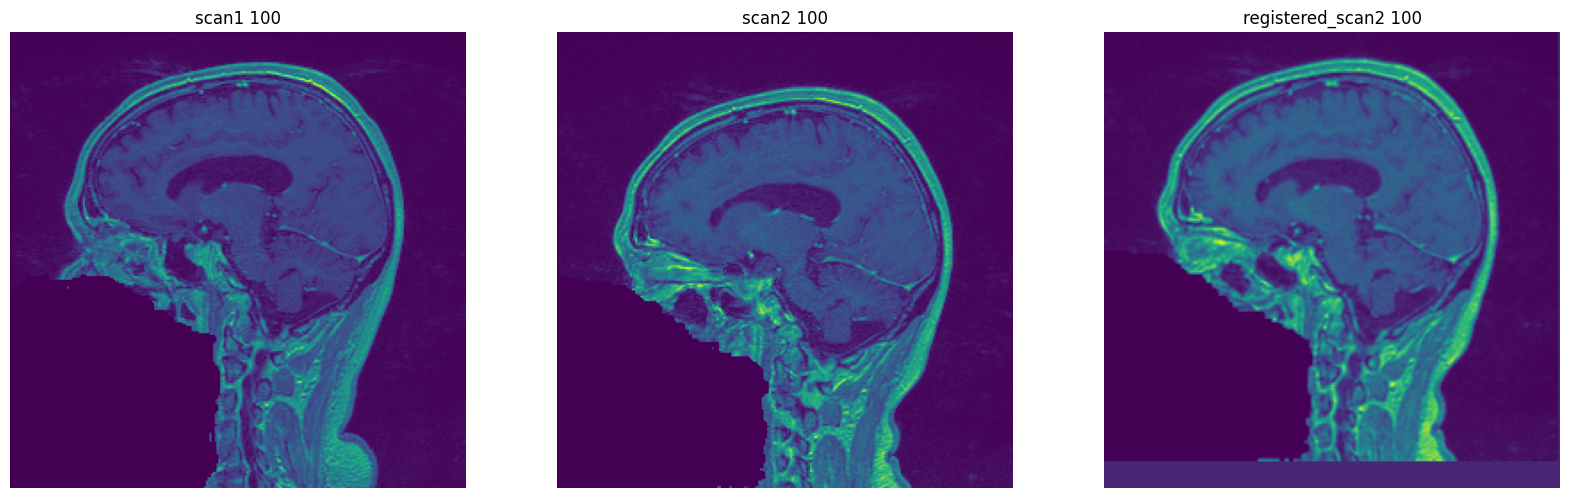

In [63]:
registered_scan2 = apply_transform(final_transform, scan1, scan2)

show_images([scan1, scan2, registered_scan2], 100,
            ["scan1", "scan2", "registered_scan2"])


# Segmentation

In [ ]:
# Set the seed point for region growing (you can change these values)
seed_point = itk.Index[3]()
seed_point[0] = 100
seed_point[1] = 100
seed_point[2] = 50

# Define the connected threshold filter
connected_threshold_filter = itk.ConnectedThresholdImageFilter[itk.F, itk.F].New()
connected_threshold_filter.SetInput(scan1)
connected_threshold_filter.SetLower(100)  # Adjust these thresholds as needed
connected_threshold_filter.SetUpper(200)  # Adjust these thresholds as needed
connected_threshold_filter.SetSeed(seed_point)

# Perform segmentation
connected_threshold_filter.Update()

# Get the segmented image
segmented_image = connected_threshold_filter.GetOutput()

TemplateTypeError: itk.ConnectedThresholdImageFilter is not wrapped for input type `itk.F, itk.F`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.ConnectedThresholdImageFilter.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.ConnectedThresholdImageFilter[itk.Image[itk.SS,2], itk.Image[itk.SS,2]].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.Image[itk.SS,2]
itk.Image[itk.SS,3]
itk.Image[itk.SS,4]
itk.Image[itk.UC,2]
itk.Image[itk.UC,3]
itk.Image[itk.UC,4]
itk.Image[itk.US,2]
itk.Image[itk.US,3]
itk.Image[itk.US,4]
itk.Image[itk.F,2]
itk.Image[itk.F,3]
itk.Image[itk.F,4]
itk.Image[itk.D,2]
itk.Image[itk.D,3]
itk.Image[itk.D,4]
